# FCOS: A Simple One-Stage and Anchor-Free Object Detector

In this exercise I implemented a **one-stage** object detector based on [FCOS: Fully-Convolutional One-Stage Object Detection](https://arxiv.org/abs/1904.01355) and train it to detect a set of object classes.
The detector design is highly similar to FCOS itself, except I trained a smaller model with slightly different hyperparameters.

We will also evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

## Setup Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "EECS598/A4 2"
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['a4_helper.py', '.DS_Store', 'eecs598', '__pycache__', 'VOCtrainval_06-Nov-2007.tar', 'voc07_train.json', 'voc07_val.json', 'VOCdevkit', 'fcos_detector.pt', 'common.py', 'one_stage_detector.py', 'two_stage_detector.ipynb', 'two_stage_detector.py', 'one_stage_detector.ipynb']


In [4]:
import os
import time

os.environ["TZ"] = "US/Eastern"
time.tzset()

from common import hello_common
from one_stage_detector import hello_one_stage_detector
from a4_helper import hello_helper


hello_common()
hello_one_stage_detector()
hello_helper()

one_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, "one_stage_detector.py")
one_stage_detector_edit_time = time.ctime(
    os.path.getmtime(one_stage_detector_path)
)
print("one_stage_detector.py last edited on %s" % one_stage_detector_edit_time)

Hello from common.py!
Hello from one_stage_detector.py!
Hello from a4_helper.py!
one_stage_detector.py last edited on Tue Mar 29 00:44:48 2022


Load several useful packages that are used in this notebook:

In [5]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from a4_helper import *
from eecs598 import reset_seed
from eecs598.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# To download the dataset
!pip install wget

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9e7f252395b1d4736bb77f1372488ab9072c05163dcc5d0e0f6c78370ba2f673
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (321/321), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


## Load PASCAL VOC 2007 data

I will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.
Run the following two cells to set a few config parameters and then download the train/val sets for the PASCAL VOC 2007 dataset.

In [7]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 20
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = multiprocessing.cpu_count()

### Download the dataset first.

In [8]:
from a4_helper import VOC2007DetectionTiny

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# Turn it back to `False` later for faster execution in the future.
# If this hangs, download and place data in your drive manually as shown above.
train_dataset = VOC2007DetectionTiny(
    GOOGLE_DRIVE_PATH, "train", image_size=IMAGE_SHAPE[0],
    download=False  # True (for the first time)
)
val_dataset = VOC2007DetectionTiny(GOOGLE_DRIVE_PATH, "val", image_size=IMAGE_SHAPE[0])

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")

Dataset sizes: train (2501), val (2510)


To train our detector, we need to convert individual images (JPEG) and annotations (XML files) into batches of tensors. We perform this by wrapping our datasets with a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object.

In [9]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `image` of shape `(B, 3, IMAGE_SHAPE[0], IMAGE_SHAPE[1])`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `gt_boxes` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `gt_boxes[i, j] = (x1, y1, x2, y2, C)` gives information about the `j`th object in `image[i]`. The position of the top-left corner of the box is `(x1, y1)` and the position of the bottom-right corner of the box is `(x2, x2)`. These coordinates are real-valued in `[0, 224]`. `C` is an integer giving the category label for this bounding box. This `(x1, y1, x2, y2)` format for bounding boxes is commonly referred as XYXY format.

Each image can have different numbers of objects. If `image[i]` has $N_i$ objects, then $N = \max_i(N_i)$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of `gt_boxes[i]` contain annotations; the remaining rows are padded with -1.

In [10]:
train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = train_loader_iter.next()

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000012.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000017.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000023.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000026.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000032.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000033.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000034.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000035.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000036.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000042.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000044.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000047.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGImages/000048.jpg', 'drive/My Drive/EECS598/A4 2/VOCdevkit/VOC2007/JPEGI

## Visualize PASCAL VOC 2007

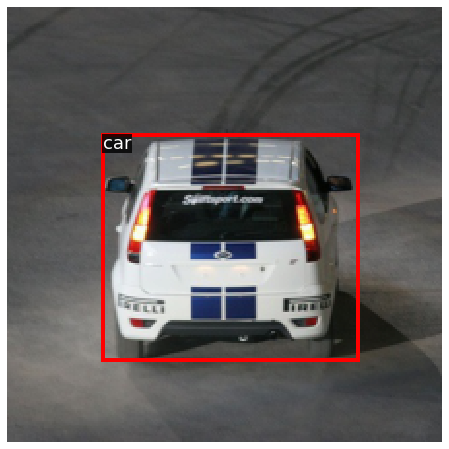

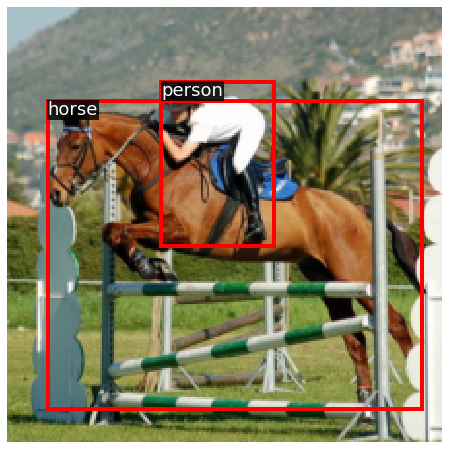

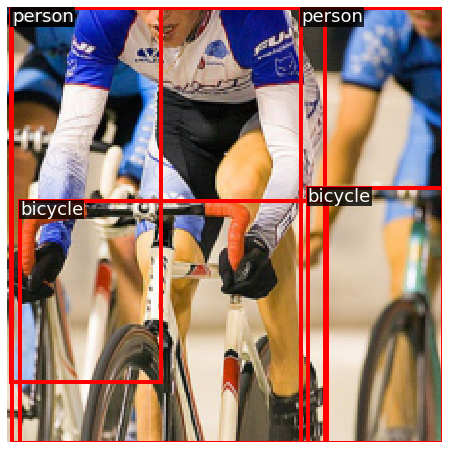

In [11]:
from torchvision import transforms
from eecs598.utils import detection_visualizer

# Define an "inverse" transform for the image that un-normalizes by ImageNet color
# and mean. Without this, the images will NOT be visually understandable.
inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    # Stop after visualizing three images.
    if idx > 2:
        break

    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(image)

    # Remove padded boxes from visualization.
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

## Implementing FCOS

FCOS is a fully-convolutional one-stage object detection model — unlike two-stage detectors like Faster R-CNN, it does not comprise any custom modules like anchor boxes, RoI pooling/align, and RPN proposals (for second stage). Due to its simplicity, you will implement core components of FCOS in this first half of the assignment, and then re-use many of them to implement Faster R-CNN in the second half.

An overview of the model in shown below. In case it does not load, see [Figure 2 in FCOS paper](https://arxiv.org/abs/1904.01355).
It details three modeling components: backbone, feature pyramid network (FPN), and head (prediction layers).
First, we will implement FCOS as shown in this figure, and then implement components to train it with the PASCAL VOC 2007 dataset we loaded above.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_3.34.09_PM_SAg1OBo.png" alt="FCOS Model Figure" width="80%">

## Implementing Backbone and Feature Pyramid Network

First,  building the backbone and FPN of detector (blue and green parts above). It is the core component that takes in an image and outputs its features of different scales. It can be any type of convolutional network that progressively downsamples the image (e.g. via intermediate max pooling).

Here, use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab.

In [12]:
import torch
from common import DetectorBackboneWithFPN

backbone = DetectorBackboneWithFPN(out_channels=64)

Downloading: "https://download.pytorch.org/models/regnet_x_400mf-adf1edd5.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-adf1edd5.pth


  0%|          | 0.00/21.3M [00:00<?, ?B/s]

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


In `common.py`, implement additional FPN layers for transforming `(c3, c4, c5)` to `(p3, p4, p5)`.
For training a small enough model on Google Colab, we leave out `(p6, p7)` as shown in the Figure.
Output features from these FPN levels are expected to have same height and width as backbone features, but now they should have the same number of channels.

In [13]:
print("Extra FPN modules added:")
print(backbone.fpn_params)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

print(f"For dummy input images with shape: {dummy_images.shape}")
for level_name, feat in dummy_fpn_feats.items():
    print(f"Shape of {level_name} features: {feat.shape}")

Extra FPN modules added:
ModuleDict(
  (c3_conv1*1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (p3_conv3*3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4_conv1*1): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (p4_conv3*3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c5_conv1*1): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (p5_conv3*3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 28, 28])
Shape of p4 features: torch.Size([2, 64, 14, 14])
Shape of p5 features: torch.Size([2, 64, 7, 7])


## Implementing FCOS prediction network (head)

In [14]:
from one_stage_detector import FCOSPredictionNetwork

# Tiny head with `in_channels` as FPN output channels in prior cell,
# and two conv layers in stem.
pred_net = FCOSPredictionNetwork(
    num_classes=NUM_CLASSES, in_channels=64, stem_channels=[64, 64]
)

print("FCOS prediction network parameters:")
print(pred_net)

# Pass the dummy output from FPN (obtained in previous cell) to the head.
dummy_preds = pred_net(dummy_fpn_feats)

pred_cls_logits, pred_boxreg_deltas, pred_ctr_logits = dummy_preds

print("Classification logits:")
for level_name, feat in pred_cls_logits.items():
    print(f"Shape of {level_name} predictions: {feat.shape}")

print("Box regression deltas:")
for level_name, feat in pred_boxreg_deltas.items():
    print(f"Shape of {level_name} predictions: {feat.shape}")

print("Centerness logits:")
for level_name, feat in pred_ctr_logits.items():
    print(f"Shape of {level_name} predictions: {feat.shape}")

FCOS prediction network parameters:
FCOSPredictionNetwork(
  (stem_cls): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (stem_box): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pred_cls): Conv2d(64, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pred_box): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pred_ctr): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Classification logits:
Shape of p3 predictions: torch.Size([2, 784, 20])
Shape of p4 predictions: torch.Size([2, 196, 20])
Shape of p5 predictions: torch.Size([2, 49, 20])
Box regression deltas:
Shape of p3 predictions: torch.Size([2, 784, 4])
Shape of p4 predictions: torch.Si

## Assigning a GT target to every model prediction

FCOS heads make three predictions at every location: object class, bounding box, and centerness.
We need to assign a GT target for each of them during training. All three predictions correspond to a single location on an FPN level `(p3, p4, p5)`, so instead we can view this problem as assigning GT boxes (and their class labels) to every FPN feature map location.

GT boxes are available (from the dataloader) as 5D vectors `(x1, y1, x2, y2, C)` where `(x1, y1)` is the top-left co-ordinate and `(x2, y2)` is the bottom-right co-ordinate of the bounding box, and `C` is its object class label. These co-ordinates are absolute and real-valued in image dimensions. To begin with the assignment, we will represent every location on an FPN level with `(xc, yc)` absolute and real-valued co-ordinates of a point on the image, that are centers of the receptive fields of those features.

For example, given features from FPN level having shape `(batch_size, channels, H / stride, W / stride)` and the location `feature[:, :, i, j]` will map to the image pixel `(stride * (i + 0.5), stride * (j + 0.5))` - 0.5 indicates the shift from top-left corner to the center of "stride box".

First five locations per FPN level (absolute image co-ordinates):
p3: [[4.0, 4.0], [12.0, 4.0], [20.0, 4.0], [28.0, 4.0], [36.0, 4.0]]
rel error:  0.0
p4: [[8.0, 8.0], [24.0, 8.0], [40.0, 8.0], [56.0, 8.0], [72.0, 8.0]]
rel error:  0.0
p5: [[16.0, 16.0], [48.0, 16.0], [80.0, 16.0], [112.0, 16.0], [144.0, 16.0]]
rel error:  0.0
********************************************************************************
All locations of the image FPN level = p3
stride = 8


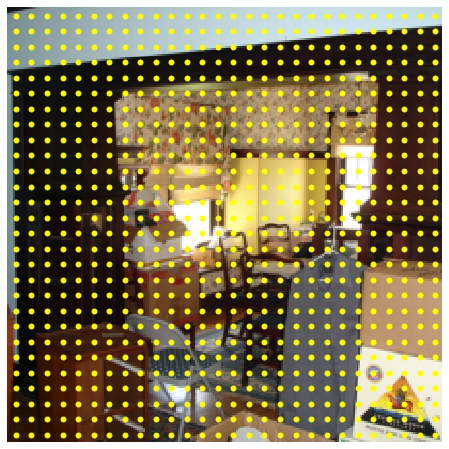

********************************************************************************
All locations of the image FPN level = p4
stride = 16


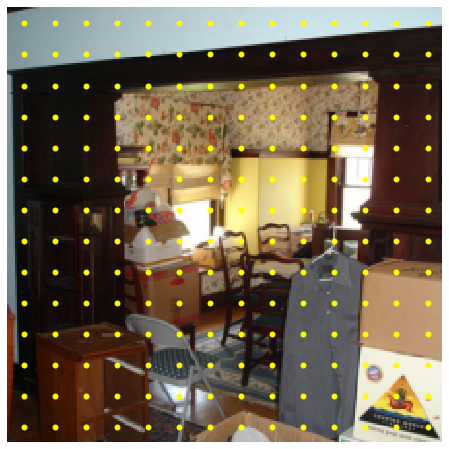

********************************************************************************
All locations of the image FPN level = p5
stride = 32


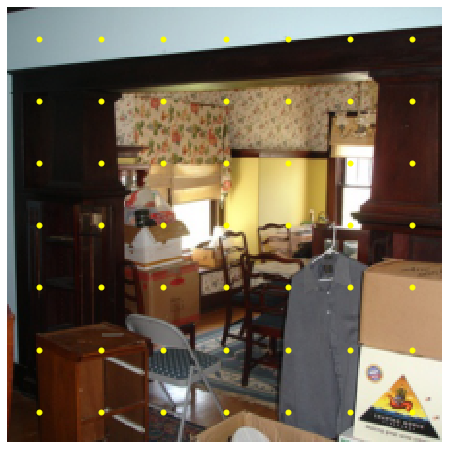

In [15]:
from common import get_fpn_location_coords

# Get shapes of each FPN level feature map. We don't call these "dummy" because
# they don't depend on the _values_ of features, but rather only shapes.
fpn_feats_shapes = {
    level_name: feat.shape for level_name, feat in dummy_fpn_feats.items()
}

# Get CPU tensors for this sanity check: (you can pass `device=` argument.
locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, backbone.fpn_strides)

# First five location co-ordinates for each feature maps.
expected_locations = {
    "p3": torch.tensor([[4.0, 4.0], [12.0, 4.0], [20.0, 4.0], [28.0, 4.0], [36.0, 4.0]]),
    "p4": torch.tensor([[8.0, 8.0], [24.0, 8.0], [40.0, 8.0], [56.0, 8.0], [72.0, 8.0]]),
    "p5": torch.tensor([[16.0, 16.0], [48.0, 16.0], [80.0, 16.0], [112.0, 16.0], [144.0, 16.0]]),
}

print("First five locations per FPN level (absolute image co-ordinates):")
for level_name, locations in locations_per_fpn_level.items():
    print(f"{level_name}: {locations[:5, :].tolist()}")
    print("rel error: ", rel_error(expected_locations[level_name], locations[:5, :]))

# Visualize all the locations on first image from training data.
for level_name, locations in locations_per_fpn_level.items():
    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(val_dataset[0][1])

    print("*" * 80)
    print(f"All locations of the image FPN level = {level_name}")
    print(f"stride = {backbone.fpn_strides[level_name]}")
    detection_visualizer(image, val_dataset.idx_to_class, points=locations.tolist())

**NOTE:** We will use "feature map location" and "feature center" interchangeably from now on, they mean the same thing — center of the receptive field of a particular feature map location at any FPN level **(yellow points above)**.

### Matching feature map locations with GT boxes

Now we match these locations with GT boxes for supervising our network. FCOS matches some `N` locations at any given FPN level with `M` GT boxes applying two rules:

> Location $N_i$ is matched with box $M_i$ if it lies inside the box. If any location lies inside two boxes, then it is matched with the smaller box. If a location does not lie inside any box, it is assigned "background".

> _Multi-scale matching_ for different FPN levels — for a particular FPN level, FCOS only considers a subset of boxes based on their size. Intuitively, larger boxes are assigned to `p5` and smaller boxes are assigned to `p3`.

As a result of this matching, each location wil receive a bounding box and a class label (that is 5D vector `(x1, y1, x2, y2, C)`) out of `M` GT boxes, or a background `(-1, -1, -1, -1, -1)`.

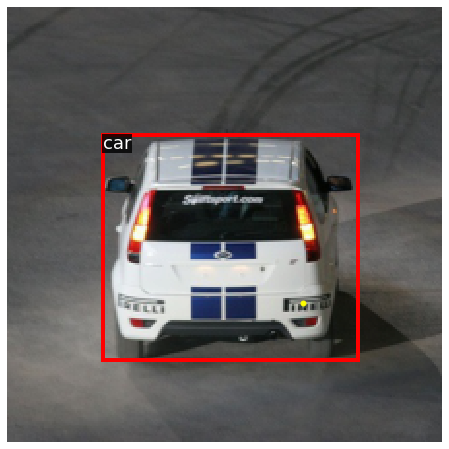

In [16]:
import random
from one_stage_detector import fcos_match_locations_to_gt

# Get an image and its GT boxes from train dataset.
_, image, gt_boxes = train_dataset[0]

# Dictionary with keys {"p3", "p4", "p5"} and values as `(N, 5)` tensors
# giving matched GT boxes.
matched_boxes_per_fpn_level = fcos_match_locations_to_gt(
    locations_per_fpn_level, backbone.fpn_strides, gt_boxes
)

# Visualize one selected location (yellow point) and its matched GT box (red).
# Get indices of matched locations (whose class ID is not -1) from P3 level.
FPN_LEVEL = "p4"
fg_idxs_p3 = (matched_boxes_per_fpn_level[FPN_LEVEL][:, 4] != -1).nonzero()

# NOTE: Run this cell multiple times to see different matched points. For car
# image, p3/5 will not work because the one and only box was already assigned
# to p4 due to its compatible size to p4 stride.
_idx = random.choice(fg_idxs_p3)

detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=matched_boxes_per_fpn_level[FPN_LEVEL][_idx],
    points=locations_per_fpn_level[FPN_LEVEL][_idx]
)

In the above illustration, we can see one random location on `p3` level (**yellow**), and its matched GT box (**red**).
With these GT targets assigned, the FCOS preiction heads are task to predict this class label (**person**) at the given location, regress the distances between this location to all box edges `(left, top, right, bottom)`, and regress a real-valued centerness at this location. 

From now on, it would help to think about FCOS behavior for a _single_ location, assuming that it has a matched GT box (or background). We shall now discuss and implement the output format of prediction layers and loss functions during training.

## GT Targets for box regression

The box regression head is tasked with predicting FOUR values: distances from feature locations (**yellow points**) to box edges (**red box**) as we discussed above `(left, top, right, bottom)` or simply as we could call it — `LTRB`.
Recall that all locations and GT boxes so far are represented in absolute image co-ordinates — they range from `(0, 224)` for our input image, and can be even larger for abritrarily large input images.

We cannot use this absolute co-ordinate format with our network because regressing to such large real-valued numbers will cause the gradients to explode.
Hence, FCOS normalizes `LTRB` targets by the `stride` of FPN levels. Hence in the above example, consider FPN level P3 (`stride = 8`), the location to be `(xc, yc)` (**yellow point**) and matched GT box have co-ordinates `(x1, y1, x2, y2)`. Then the `LTRB` regression targets used to supervise the network are:

    l = (xc - x1) / stride              t = (yc - y1) / stride
    r = (x2 - xc) / stride              b = (y2 - yc) / stride

These are commonly referred as "deltas" of box regression. Since the model is supervised to predict these during training time, one must apply an inverse transformation to these during inference to convert network outputs to predicted boxes in absolute image co-ordinates.

In [17]:
import torch

from one_stage_detector import fcos_get_deltas_from_locations, fcos_apply_deltas_to_locations

# Three hard-coded input boxes and three points lying inside them.
# Add a dummy class ID = 1 indicating foreground
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)
input_locations = torch.Tensor([[30, 40], [32, 29], [125, 150]])

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to centers should give us the same boxes. Setting a random
# stride = 8, it should not affect reconstruction if it is same on both sides.
_deltas = fcos_get_deltas_from_locations(input_locations, input_boxes, stride=8)
output_boxes = fcos_apply_deltas_to_locations(_deltas, input_locations, stride=8)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))


# Another check: deltas for GT class label = -1 should be -1.
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_location = torch.Tensor([[100, 200]])

_deltas = fcos_get_deltas_from_locations(input_location, background_box, stride=8)
output_box = fcos_apply_deltas_to_locations(_deltas, input_location, stride=8)

print("Background deltas should be all -1    :", _deltas)

# Output box should be the location itself ([100, 200, 100, 200])
print("Output box with background deltas     :", output_box)

Rel error in reconstructed boxes: 0.0
Background deltas should be all -1    : tensor([[-1., -1., -1., -1.]])
Output box with background deltas     : tensor([[100., 200., 100., 200.]])


## GT targets for centerness regression

Given the GT deltas for a location `(left, top, right, bottom)` as computed above, FCOS defines centerness as:

$$centerness = \sqrt{\frac{\min(left, right) \cdot \min(top, bottom)}{\max(left, right) \cdot \max(top, bottom)}}$$

This value is maximum (1) when `left = right` and `top = bottom`, implying the center of GT box.
At the edge of a box, one of these values will be zero, which gives zero centerness at edges.
Centerness regression head uses these values as targets — you need to implement them next in `fcos_make_centerness_targets`.

In [18]:
import torch

from one_stage_detector import fcos_make_centerness_targets

# Three hard-coded input boxes and three points lying inside them.
# Add a dummy class ID = 1 indicating foreground
input_boxes = torch.Tensor(
    [
        [10, 15, 100, 115, 1],
        [30, 20, 40, 30, 1],
        [-1, -1, -1, -1, -1]  # background
    ]
)
input_locations = torch.Tensor([[30, 40], [32, 29], [125, 150]])

expected_centerness = torch.Tensor([0.30860671401, 0.1666666716, -1.0])

_deltas = fcos_get_deltas_from_locations(input_locations, input_boxes, stride=8)
centerness = fcos_make_centerness_targets(_deltas)
print("Rel error in centerness:", rel_error(centerness, expected_centerness))

Rel error in centerness: 0.0


## Loss Functions

At this point, every model prediction is assigned a GT target during training.
We will proceed to compute losses for training the model.

FCOS has three prediction layers, that use the following use functions:

1. **Object classification:** FCOS uses [Focal Loss](https://arxiv.org/abs/1708.02002), an extension of cross-entropy loss that deals with class-imbalance. FCOS faces a class imbalance issue because a majority of locations would be assigned "background". If not handled properly, the model will simply learn to predict "background" for every location.

2. **Box regression:** We will use a simple L1 loss to minimize the difference between predicted and GT `LTRB` deltas. FCOS uses [Generalized Intersection-over-Union](https://giou.stanford.edu/) loss, which empirically gives slightly better results but is slightly slower — we use L1 loss due to Colab time limits. (You are not required to understand GIoU for this assignment)

3. **Centerness regression:** Centerness predictions and GT targets are real-valued numbers in `[0, 1]`, so FCOS uses binary cross-entropy (BCE) loss to optimize it. One may use an L1 loss, but BCE empirically works slightly better.

**Total loss:** We get three loss components _per location_. Out of these, (2) and (3) are set to zero for _background locations_ because their GT boxes (and hence centerness) are not defined. Total loss is the sum of all losses per location, averaged by the number of _foreground locations_ (that matched with any GT box). The number of foreground locations are highly variable per image, depending on density of objects in it. Hence for training stability, the loss is instead average by an _exponential moving average of foreground locations_ (think like the running mean/var of BN, in past assignment).

In [19]:
import torch
from torchvision.ops import sigmoid_focal_loss


# Sanity check: dummy model predictions for TWO locations, and
# NUM_CLASSES = 5 (typically there are thousands of locations
# across all FPN levels).
# shape: (batch_size, num_locations, num_classes)
dummy_pred_cls_logits = torch.randn(1, 2, 5)

# Corresponding one-hot vectors of GT class labels (2, -1), one
# foreground and one background.
# shape: (batch_size, num_locations, num_classes)
dummy_gt_classes = torch.Tensor([[[0, 0, 1, 0, 0], [0, 0, 0, 0, 0]]])

# This loss expects logits, not probabilities (DO NOT apply sigmoid!)
cls_loss = sigmoid_focal_loss(
    inputs=dummy_pred_cls_logits, targets=dummy_gt_classes
)
print("Classification loss (dummy inputs/targets):")
print(cls_loss)

print(f"Total classification loss (un-normalized): {cls_loss.sum()}")

Classification loss (dummy inputs/targets):
tensor([[[0.2302, 0.0539, 0.0292, 0.5227, 0.0432],
         [0.0283, 0.2665, 0.1984, 0.2696, 0.0909]]])
Total classification loss (un-normalized): 1.7328040599822998


In [20]:
from torch.nn import functional as F
from one_stage_detector import fcos_get_deltas_from_locations


# Sanity check: dummy model predictions for TWO locations, and
# NUM_CLASSES = 2 (typically there are thousands of locations
# across all FPN levels).
# Think of these as first two locations locations of "p5" level.
dummy_locations = torch.Tensor([[32, 32], [64, 32]])
dummy_gt_boxes = torch.Tensor(
    [
        [1, 2, 40, 50, 2],
        [-1, -1, -1, -1, -1]  # Same GT classes as above cell.
    ]
)
# Centerness is just a dummy value:
dummy_gt_centerness = torch.Tensor([0.6, -1])

# shape: (batch_size, num_locations, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_ctr_logits = torch.randn(1, 2, 1)

# Collapse batch dimension.
dummy_pred_boxreg_deltas = dummy_pred_boxreg_deltas.view(-1, 4)
dummy_pred_ctr_logits = dummy_pred_ctr_logits.view(-1)

# First calculate box reg loss, comparing predicted boxes and GT boxes.
dummy_gt_deltas = fcos_get_deltas_from_locations(
    dummy_locations, dummy_gt_boxes, stride=32
)
# Multiply with 0.25 to average across four LTRB components.
loss_box = 0.25 * F.l1_loss(
    dummy_pred_boxreg_deltas, dummy_gt_deltas, reduction="none"
)

# No loss for background:
loss_box[dummy_gt_deltas < 0] *= 0.0
print("Box regression loss (L1):", loss_box)


# Now calculate centerness loss.
centerness_loss = F.binary_cross_entropy_with_logits(
    dummy_pred_ctr_logits, dummy_gt_centerness, reduction="none"
)
# No loss for background:
centerness_loss[dummy_gt_centerness < 0] *= 0.0
print("Centerness loss (BCE):", centerness_loss)

# In the expected loss, the first value will be different everytime due to random dummy
# predictions. But the second value should always be zero - corresponding to background.

Box regression loss (L1): tensor([[0.2715, 0.5367, 0.0077, 0.3772],
        [0.0000, 0.0000, 0.0000, 0.0000]])
Centerness loss (BCE): tensor([0.7093, -0.0000])


## Object detection module

We will now combine everything into the `FCOS` class in `one_stage_detector.py`.

## Overfit small data

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 3.263][loss_cls: 0.698][loss_box: 2.136][loss_ctr: 0.429]
[Iter 20][loss: 5.063][loss_cls: 1.111][loss_box: 3.272][loss_ctr: 0.680]
[Iter 40][loss: 4.217][loss_cls: 1.181][loss_box: 2.314][loss_ctr: 0.722]
[Iter 60][loss: 3.811][loss_cls: 1.097][loss_box: 1.989][loss_ctr: 0.725]
[Iter 80][loss: 3.198][loss_cls: 0.749][loss_box: 1.727][loss_ctr: 0.722]
[Iter 100][loss: 3.113][loss_cls: 0.663][loss_box: 1.731][loss_ctr: 0.720]
[Iter 120][loss: 3.251][loss_cls: 0.902][loss_box: 1.631][loss_ctr: 0.718]
[Iter 140][loss: 3.795][loss_cls: 0.668][loss_box: 2.417][loss_ctr: 0.709]
[Iter 160][loss: 3.177][loss_cls: 0.672][loss_box: 1.791][loss_ctr: 0.714]
[Iter 180][loss: 3.866][loss_cls: 0.672][loss_box: 2.482][loss_ctr: 0.712]
[Iter 200][loss: 3.299][loss_cls: 0.759][loss_box: 1.8

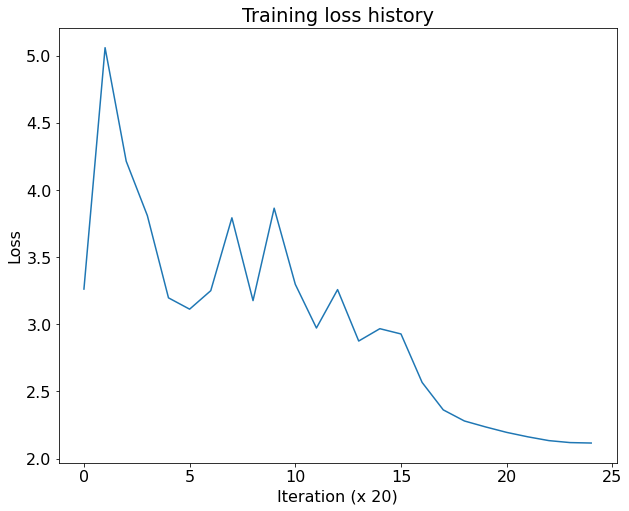

In [21]:
from a4_helper import train_detector
from one_stage_detector import FCOS

reset_seed(0)

# Take equally spaced examples from training dataset to make a subset.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

detector = FCOS(
    num_classes=NUM_CLASSES,
    fpn_channels=64,
    stem_channels=[64, 64],
)
detector = detector.to(DEVICE)

train_detector(
    detector,
    small_train_loader,
    learning_rate=5e-3,
    max_iters=500,
    log_period=20,
    device=DEVICE,
)

## Train a net

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 2.528][loss_cls: 0.526][loss_box: 1.680][loss_ctr: 0.322]
[Iter 100][loss: 2.788][loss_cls: 0.723][loss_box: 1.412][loss_ctr: 0.653]
[Iter 200][loss: 2.719][loss_cls: 0.606][loss_box: 1.459][loss_ctr: 0.654]
[Iter 300][loss: 2.204][loss_cls: 0.554][loss_box: 1.022][loss_ctr: 0.628]
[Iter 400][loss: 2.259][loss_cls: 0.454][loss_box: 1.128][loss_ctr: 0.678]
[Iter 500][loss: 1.974][loss_cls: 0.356][loss_box: 1.047][loss_ctr: 0.572]
[Iter 600][loss: 1.823][loss_cls: 0.407][loss_box: 0.870][loss_ctr: 0.547]
[Iter 700][loss: 1.925][loss_cls: 0.325][loss_box: 0.984][loss_ctr: 0.616]
[Iter 800][loss: 1.652][loss_cls: 0.277][loss_box: 0.821][loss_ctr: 0.553]
[Iter 900][loss: 1.836][loss_cls: 0.326][loss_box: 0.912][loss_ctr: 0.598]
[Iter 1000][loss: 1.792][loss_cls: 0.316][loss_box

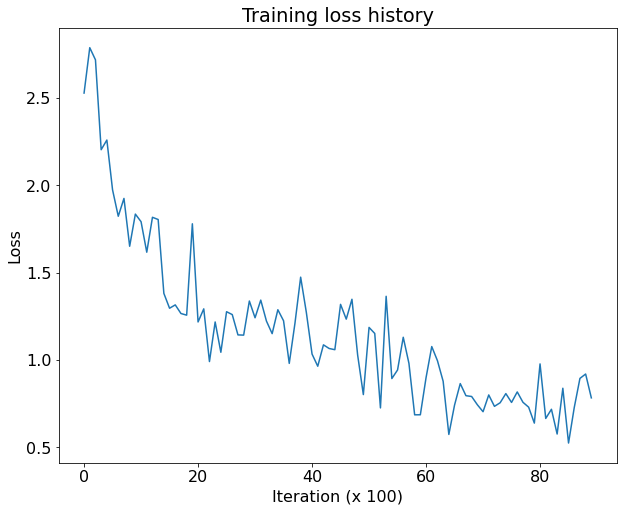

In [22]:
reset_seed(0)

# Slightly larger detector than in above cell.
detector = FCOS(
    num_classes=NUM_CLASSES,
    fpn_channels=128,
    stem_channels=[128, 128],
)
detector = detector.to(DEVICE)

train_detector(
    detector,
    train_loader,
    learning_rate=8e-3,
    max_iters=9000,
    log_period=100,
    device=DEVICE,
)

# After you've trained your model, save the weights for submission.
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "fcos_detector.pt")
torch.save(detector.state_dict(), weights_path)

## Non-Maximum Suppression (NMS)

Implement the `nms` function in `common.py`.

In [23]:
# Perform imports here to make this cell runnble independently,
# students are likely to spend good mount of time here and it is
# best to not require execution of prior cells.
import time
import torch
import torchvision

from common import nms
from eecs598 import reset_seed

reset_seed(0)


boxes = (100.0 * torch.rand(5000, 4)).round()
boxes[:, 2] = boxes[:, 2] + boxes[:, 0] + 1.0
boxes[:, 3] = boxes[:, 3] + boxes[:, 1] + 1.0
scores = torch.randn(5000)

names = ["your_cpu", "torchvision_cpu", "torchvision_cuda"]
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.0] * len(names)))
intersects = dict(zip(names[1:], [0.0] * (len(names) - 1)))

for iou_threshold in iou_thresholds:
    tic = time.time()
    my_keep = nms(boxes, scores, iou_threshold)
    elapsed["your_cpu"] += time.time() - tic

    tic = time.time()
    tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
    elapsed["torchvision_cpu"] += time.time() - tic
    intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
    intersects["torchvision_cpu"] += intersect

    tic = time.time()
    tv_cuda_keep = torchvision.ops.nms(boxes.to(device=DEVICE), scores.to(device=DEVICE), iou_threshold).to(
        my_keep.device
    )
    torch.cuda.synchronize()
    elapsed["torchvision_cuda"] += time.time() - tic
    intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(
        tv_cuda_keep
    )
    intersects["torchvision_cuda"] += intersect

for key in intersects:
    intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print("Testing NMS:")
print("Your        CPU  implementation: %fs" % elapsed["your_cpu"])
print("torchvision CPU  implementation: %fs" % elapsed["torchvision_cpu"])
print("torchvision CUDA implementation: %fs" % elapsed["torchvision_cuda"])
print("Speedup CPU : %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cpu"]))
print("Speedup CUDA: %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cuda"]))
print(
    "Difference CPU : ", 1.0 - intersects["torchvision_cpu"]
)  # in the order of 1e-3 or less
print(
    "Difference CUDA: ", 1.0 - intersects["torchvision_cuda"]
)  # in the order of 1e-3 or less

Testing NMS:
Your        CPU  implementation: 0.876323s
torchvision CPU  implementation: 0.064902s
torchvision CUDA implementation: 0.028520s
Speedup CPU : 13.502243x
Speedup CUDA: 30.726257x
Difference CPU :  0.0018764619378015546
Difference CUDA:  0.0037739951446327247


## Inference

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


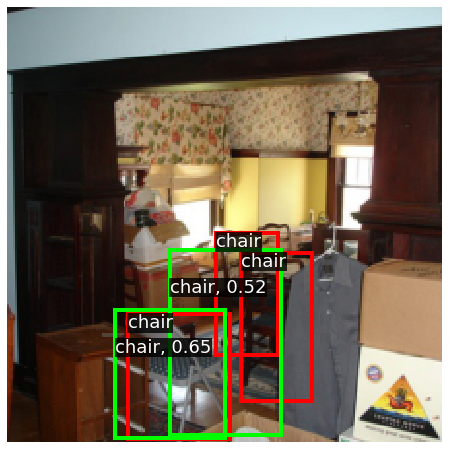

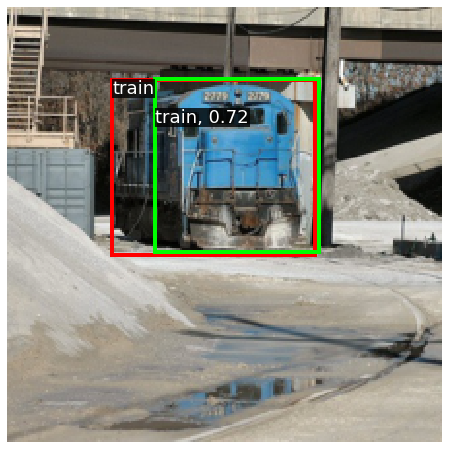

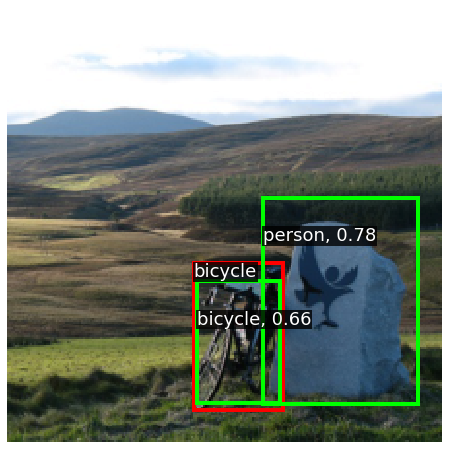

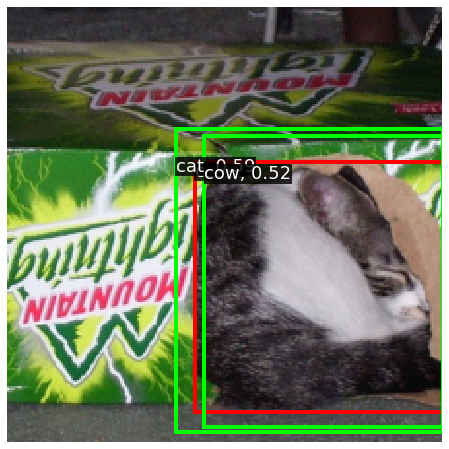

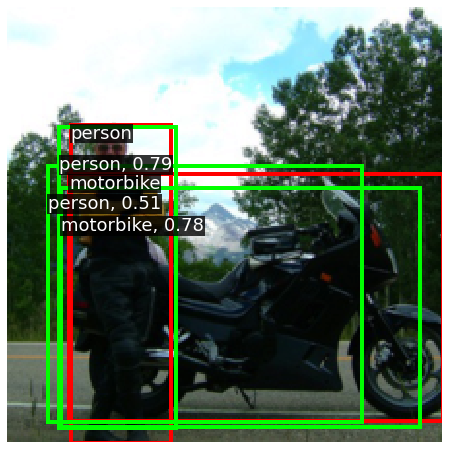

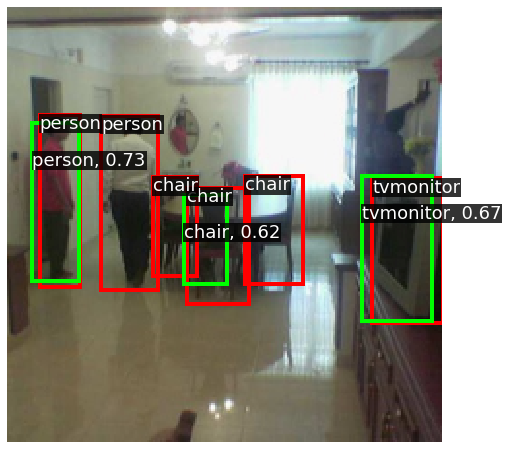

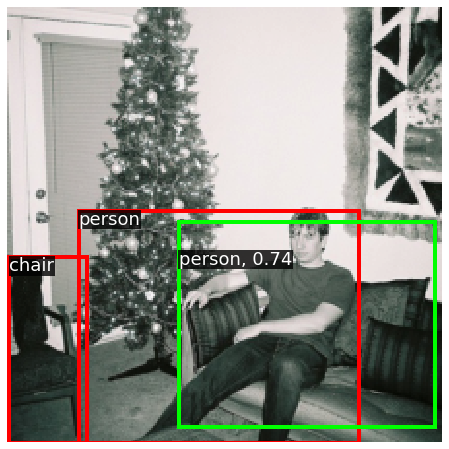

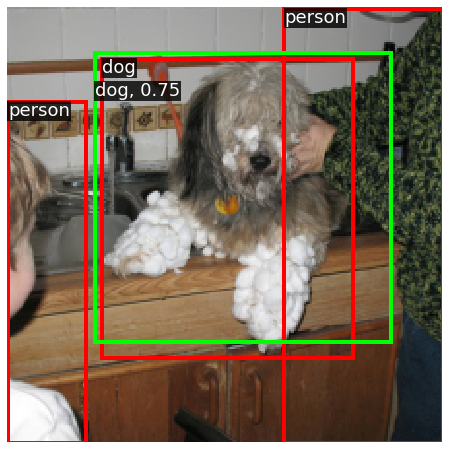

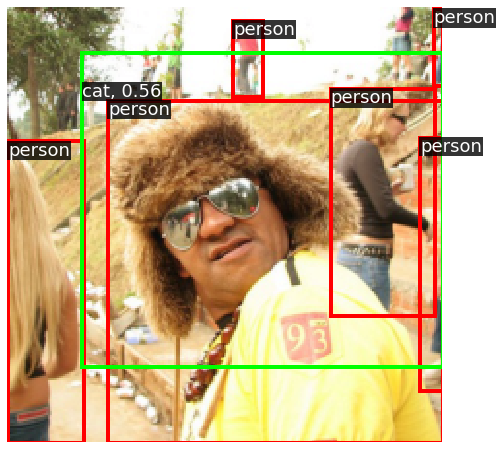

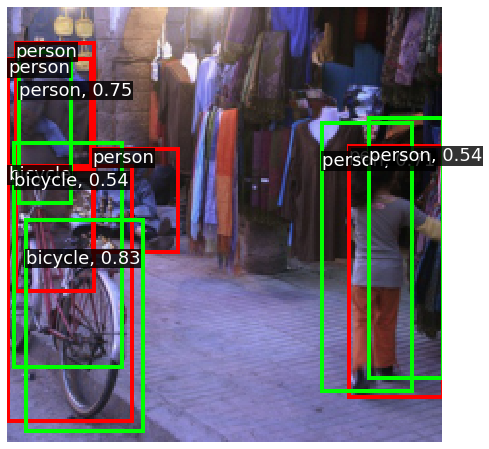

Total inference time: 3.8s


In [24]:
from a4_helper import inference_with_detector
from one_stage_detector import FCOS


weights_path = os.path.join(GOOGLE_DRIVE_PATH, "fcos_detector.pt")

# Re-initialize so this cell is independent from prior cells.
detector = FCOS(
    num_classes=NUM_CLASSES, fpn_channels=128, stem_channels=[128, 128]
)
detector.to(device=DEVICE)
detector.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Prepare a small val daataset for inference:
small_dataset = torch.utils.data.Subset(
    val_dataset,
    torch.linspace(0, len(val_dataset) - 1, steps=10).long()
)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    detector,
    small_val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.5,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

## Evaluation
Compute mean Average Precision (mAP).


Total inference time: 640.5s
52.56% = aeroplane AP 
49.57% = bicycle AP 
38.51% = bird AP 
24.87% = boat AP 
4.91% = bottle AP 
48.52% = bus AP 
48.95% = car AP 
63.90% = cat AP 
14.14% = chair AP 
36.51% = cow AP 
34.73% = diningtable AP 
52.48% = dog AP 
58.55% = horse AP 
48.27% = motorbike AP 
47.02% = person AP 
7.89% = pottedplant AP 
17.60% = sheep AP 
27.52% = sofa AP 
66.76% = train AP 
34.13% = tvmonitor AP 
mAP = 38.87%
<Figure size 640x480 with 1 Axes>


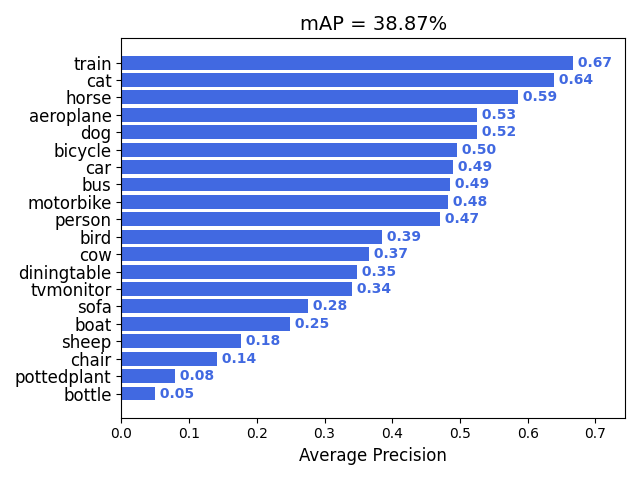

In [25]:
inference_with_detector(
    detector,
    val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.4,
    nms_thresh=0.6,
    device=DEVICE,
    dtype=torch.float32,
    output_dir="mAP/input",
)
!cd mAP && python main.py

# This script outputs an image containing per-class AP. Display it here:
from IPython.display import Image
Image(filename="./mAP/output/mAP.png")